In [1]:
from config import*
from maxwell import*
from Wfamily import*
from Model import*

/envs/common/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


family_len:  21904


In [2]:
#neural-net models

model_domain1 = WPINN(input_size = n_collocation, 
                    num_hidden_layers1 = 2, 
                    num_hidden_layers2 = 6, 
                    hidden_neurons = 50, 
                    family_size = len_family).to(device)

optimizer1 = optim.Adam(model_domain1.parameters(), lr=1e-5)#, weight_decay=1e-4)


model_domain2 = WPINN(input_size = n_collocation, 
                    num_hidden_layers1 = 2, 
                    num_hidden_layers2 = 6, 
                    hidden_neurons = 50, 
                    family_size = len_family).to(device)
optimizer2 = optim.Adam(model_domain2.parameters(), lr=1e-5)#, weight_decay=1e-4)

def lr_lambda(epoch):
    if epoch < 10000: return 1.0      
    else: return 0.1     

scheduler1 = optim.lr_scheduler.LambdaLR(optimizer1, lr_lambda=lr_lambda)
scheduler2 = optim.lr_scheduler.LambdaLR(optimizer2, lr_lambda=lr_lambda)

In [3]:
x_interior1 = x_collocation1.clone()
x_interior2 = x_collocation2.clone()
t_interior = t_collocation.clone()

def wpinn_loss(model1, model2):   
    global c1, b1, c2, b2
    c1, b1 = model1(x_collocation1, t_collocation)
    c2, b2 = model2(x_collocation2, t_collocation)

    E_pred_ic1 = torch.mv(Wic1, c1[0]) + b1[0]
    E_pred_ic2 = torch.mv(Wic2, c2[0]) + b2[0]
    H_pred_ic1 = torch.mv(Wic1, c1[1]) + b1[1]
    H_pred_ic2 = torch.mv(Wic2, c2[1]) + b2[1]
    
    E_pred_bc_left = torch.mv(Wbc_left, c1[0]) + b1[0]
    E_pred_bc_right = torch.mv(Wbc_right, c2[0]) + b2[0]
    H_pred_bc_left = torch.mv(Wbc_left, c1[1]) + b1[1]
    H_pred_bc_right = torch.mv(Wbc_right, c2[1]) + b2[1]


    E_x1 = torch.mv(DWx1, c1[0])
    E_t1 = torch.mv(DWt1, c1[0])
    H_x1 = torch.mv(DWx1, c1[1])
    H_t1 = torch.mv(DWt1, c1[1])
    
    E_x2 = torch.mv(DWx2, c2[0])
    E_t2 = torch.mv(DWt2, c2[0])
    H_x2 = torch.mv(DWx2, c2[1])
    H_t2 = torch.mv(DWt2, c2[1])
    
    E_int1 = torch.mv(Wint, c1[0]) + b1[0]
    E_int2 = torch.mv(Wint, c2[0]) + b2[0]
    H_int1 = torch.mv(Wint, c1[1]) + b1[1]
    H_int2 = torch.mv(Wint, c2[1]) + b2[1]
    
    pde_loss = torch.mean(torch.cat((E_x1+H_t1, E_x2+mu2*H_t2))**2) +\
    torch.mean(torch.cat((H_x1+E_t1, H_x2+epsilon2*E_t2))**2)

    ic_loss = torch.mean(torch.cat((E_pred_ic1-E_ic1, E_pred_ic2-E_ic2))**2) +\
    torch.mean(torch.cat((H_pred_ic1-H_ic1, H_pred_ic2-H_ic2))**2)

    bc_loss = torch.mean((E_pred_bc_left-E_bc_left)**2) + torch.mean((E_pred_bc_right-E_bc_right)**2) +\
              torch.mean((H_pred_bc_left-H_bc_left)**2) + torch.mean((H_pred_bc_right-H_bc_right)**2)

    int_loss = torch.mean((E_int1-E_int2)**2) + torch.mean((H_int1-H_int2)**2)
    
    total_loss = pde_loss + ic_loss + bc_loss + int_loss
    
    return total_loss, pde_loss, ic_loss, bc_loss

def train_wpinn(model1, model2, optimizer1, optimizer2, num_epochs, num_prints):
    # Training loop
    pde_losses = []
    bc_losses = []
    for epoch in tqdm(range(num_epochs)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()

        total_loss, pde_loss, ic_loss, bc_loss = wpinn_loss(model1, model2)
        
        total_loss.backward()
        optimizer1.step()
        optimizer2.step()
        scheduler1.step()
        scheduler2.step()
    
        
        if epoch % ((num_epochs-1)/num_prints) == 0:
            E_numerical = torch.cat((torch.mv(WValidation1, c1[0]) + b1[0], torch.mv(WValidation2, c2[0]) + b2[0]))
            H_numerical = torch.cat((torch.mv(WValidation1, c1[1]) + b1[1], torch.mv(WValidation2, c2[1]) + b2[1]))
            
            E_errL2 = (torch.sum(torch.abs(E_validation-E_numerical)**2))**0.5 / (torch.sum(torch.abs(E_validation)**2))**0.5
            E_errMax = torch.max(torch.abs(E_validation-E_numerical))

            H_errL2 = (torch.sum(torch.abs(H_validation-H_numerical)**2))**0.5 / (torch.sum(torch.abs(H_validation)**2))**0.5
            H_errMax = torch.max(torch.abs(H_validation-H_numerical))
            
            print(f'Epoch [{epoch}/{num_epochs-1}], '
                  f'Total Loss: {total_loss.item():.6f}, '
                  f'PDE Loss: {pde_loss.item():.6f}, '
                  f'IC Loss: {ic_loss.item():.6f}, '
                  f'BC Loss: {bc_loss.item():.6f}, \n'
                  f'\t\t  E:  RelativeL2: {E_errL2}, '
                  f'Max: {E_errMax} \n'
                  f'\t\t  B:  RelativeL2: {H_errL2}, '
                  f'Max: {H_errMax}\n' )
    
    return [pde_losses, ic_loss, bc_losses]

In [4]:
torch.cuda.empty_cache()

num_epochs = 3*10**4+1
num_prints = 10
train_wpinn(model_domain1, model_domain2, optimizer1, optimizer2, num_epochs, num_prints)

c1_trained = c1
b1_trained = b1
c2_trained = c2
b2_trained = b2

  0%|          | 7/30001 [00:00<15:42, 31.82it/s]

Epoch [0/30000], Total Loss: 53.084435, PDE Loss: 49.803226, IC Loss: 0.504645, BC Loss: 2.731410, 
		  E:  RelativeL2: 0.6799288392066956, Max: 1.4458122253417969 
		  B:  RelativeL2: 1.3883910179138184, Max: 1.932171106338501



 10%|█         | 3007/30001 [01:40<14:26, 31.17it/s]

Epoch [3000/30000], Total Loss: 0.000234, PDE Loss: 0.000210, IC Loss: 0.000005, BC Loss: 0.000013, 
		  E:  RelativeL2: 0.003872903063893318, Max: 0.013323187828063965 
		  B:  RelativeL2: 0.003891855711117387, Max: 0.007723495364189148



 20%|██        | 6007/30001 [03:21<13:05, 30.55it/s]

Epoch [6000/30000], Total Loss: 0.000055, PDE Loss: 0.000049, IC Loss: 0.000001, BC Loss: 0.000003, 
		  E:  RelativeL2: 0.0021074514370411634, Max: 0.009505271911621094 
		  B:  RelativeL2: 0.001982939662411809, Max: 0.0035586953163146973



 30%|███       | 9007/30001 [05:02<11:27, 30.54it/s]

Epoch [9000/30000], Total Loss: 0.000044, PDE Loss: 0.000042, IC Loss: 0.000000, BC Loss: 0.000001, 
		  E:  RelativeL2: 0.0009587869280949235, Max: 0.00482487678527832 
		  B:  RelativeL2: 0.0009738371591083705, Max: 0.0016894042491912842



 40%|████      | 12007/30001 [06:43<09:49, 30.54it/s]

Epoch [12000/30000], Total Loss: 0.000005, PDE Loss: 0.000004, IC Loss: 0.000000, BC Loss: 0.000001, 
		  E:  RelativeL2: 0.0006830826168879867, Max: 0.0031968355178833008 
		  B:  RelativeL2: 0.0007492753793485463, Max: 0.0013229846954345703



 50%|█████     | 15007/30001 [08:24<08:10, 30.54it/s]

Epoch [15000/30000], Total Loss: 0.000006, PDE Loss: 0.000005, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0005083161522634327, Max: 0.002256155014038086 
		  B:  RelativeL2: 0.0005984044983051717, Max: 0.0011539459228515625



 60%|██████    | 18007/30001 [10:05<06:32, 30.55it/s]

Epoch [18000/30000], Total Loss: 0.000004, PDE Loss: 0.000004, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0003634508466348052, Max: 0.0016472339630126953 
		  B:  RelativeL2: 0.00044113671174272895, Max: 0.0009402632713317871



 70%|███████   | 21007/30001 [11:46<04:54, 30.55it/s]

Epoch [21000/30000], Total Loss: 0.000003, PDE Loss: 0.000003, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00028834425029344857, Max: 0.0012366771697998047 
		  B:  RelativeL2: 0.0003298586525488645, Max: 0.0006784796714782715



 80%|████████  | 24007/30001 [13:27<03:16, 30.52it/s]

Epoch [24000/30000], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00023649523791391402, Max: 0.0009949207305908203 
		  B:  RelativeL2: 0.0002725997765082866, Max: 0.0005954504013061523



 90%|█████████ | 27007/30001 [15:08<01:38, 30.54it/s]

Epoch [27000/30000], Total Loss: 0.000003, PDE Loss: 0.000003, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0002044296998064965, Max: 0.0008901357650756836 
		  B:  RelativeL2: 0.00027612599660642445, Max: 0.0006976723670959473



100%|██████████| 30001/30001 [16:49<00:00, 29.73it/s]

Epoch [30000/30000], Total Loss: 0.000005, PDE Loss: 0.000005, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00017778316396288574, Max: 0.0007675886154174805 
		  B:  RelativeL2: 0.00022955206804908812, Max: 0.0004525184631347656



In [6]:
# Additional coefficient refinement training

model1_refined = CoefficientRefinementNetwork(initial_coefficients=c1_trained, initial_bias = b1_trained).to(device)
model2_refined = CoefficientRefinementNetwork(initial_coefficients=c2_trained, initial_bias = b2_trained).to(device)

refined_optimizer1 = optim.Adam(model1_refined.parameters(), lr=1e-5) 
refined_optimizer2 = optim.Adam(model2_refined.parameters(), lr=1e-5) 

num_epochs = 5*10**3+1
num_prints = 5
train_wpinn(model_domain1, model_domain2, optimizer1, optimizer2, num_epochs, num_prints)

  0%|          | 5/5001 [00:00<01:40, 49.64it/s]

Epoch [0/5000], Total Loss: 0.000015, PDE Loss: 0.000015, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0001645103475311771, Max: 0.0008500814437866211 
		  B:  RelativeL2: 0.00020157996914349496, Max: 0.0003857612609863281



 20%|██        | 1007/5001 [00:33<02:13, 29.87it/s]

Epoch [1000/5000], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00014872947940602899, Max: 0.0005747079849243164 
		  B:  RelativeL2: 0.0001836081937653944, Max: 0.00041282176971435547



 40%|████      | 2007/5001 [01:07<01:40, 29.87it/s]

Epoch [2000/5000], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00014123681467026472, Max: 0.0006153583526611328 
		  B:  RelativeL2: 0.00016789426445029676, Max: 0.0004304647445678711



 60%|██████    | 3007/5001 [01:41<01:06, 29.85it/s]

Epoch [3000/5000], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00014843804819975048, Max: 0.0006289482116699219 
		  B:  RelativeL2: 0.00014890155580360442, Max: 0.0003452301025390625



 80%|████████  | 4007/5001 [02:14<00:33, 29.85it/s]

Epoch [4000/5000], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00012379379768390208, Max: 0.0005131959915161133 
		  B:  RelativeL2: 0.0001614621578482911, Max: 0.000397413969039917



100%|██████████| 5001/5001 [02:48<00:00, 29.73it/s]

Epoch [5000/5000], Total Loss: 0.000004, PDE Loss: 0.000004, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00012829568004235625, Max: 0.0005865097045898438 
		  B:  RelativeL2: 0.00014017292414791882, Max: 0.00032579898834228516



[[], tensor(7.7516e-09, device='cuda:0', grad_fn=<AddBackward0>), []]

E:  RelativeL2: 0.00012331643665675074, Max: 0.0011613965034484863 

B:  RelativeL2: 0.00014222766913007945, Max: 0.0006564706563949585


/tmp/ipykernel_2204856/161527895.py:36: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(20,30))


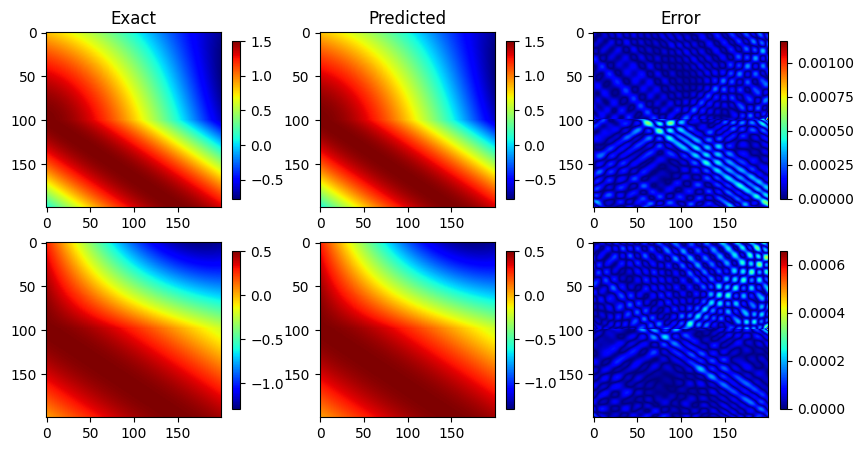

In [7]:
#Testing
with torch.no_grad():
    E_pred = torch.cat((torch.mv(WTest1, c1[0].cpu()) + b1[0].cpu(), torch.mv(WTest2, c2[0].cpu()) + b2[0].cpu()))
    H_pred = torch.cat((torch.mv(WTest1, c1[1].cpu()) + b1[1].cpu(), torch.mv(WTest2, c2[1].cpu()) + b2[1].cpu()))
    E_pred = E_pred.reshape(n_test, n_test).detach().numpy()
    H_pred = H_pred.reshape(n_test, n_test).detach().numpy()


E_errL2 = (np.sum(np.abs(E_exact-E_pred)**2))**0.5 / (np.sum(np.abs(E_exact)**2))**0.5
E_errMax = np.max(np.abs(E_exact-E_pred))

H_errL2 = (np.sum(np.abs(H_exact-H_pred)**2))**0.5 / (np.sum(np.abs(H_exact)**2))**0.5
H_errMax = np.max(np.abs(H_exact-H_pred))

print(f'E:  RelativeL2: {E_errL2}, '
      f'Max: {E_errMax} \n\n'
      f'B:  RelativeL2: {H_errL2}, '
      f'Max: {H_errMax}')

fig = plt.figure(1, figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(E_exact, cmap='jet')
plt.colorbar(shrink=0.9)
plt.title('Exact')

plt.subplot(2,3,2)
plt.imshow(E_pred, cmap='jet')
plt.colorbar(shrink=0.9)
plt.title('Predicted')

plt.subplot(2,3,3)
plt.imshow(abs(E_exact-E_pred), cmap='jet')
plt.colorbar(shrink=0.9)
plt.title('Error')

fig = plt.figure(1, figsize=(20,30))
plt.subplot(2,3,4)
plt.imshow(H_exact, cmap='jet')
plt.colorbar(shrink=0.9)

plt.subplot(2,3,5)
plt.imshow(H_pred, cmap='jet')
plt.colorbar(shrink=0.9)

plt.subplot(2,3,6)
plt.imshow(abs(H_exact-H_pred), cmap='jet')
plt.colorbar(shrink=0.9)

plt.savefig('sol.png')
plt.show()

In [42]:
np.savetxt('E_pred.csv', E_pred, delimiter=",")
np.savetxt('H_pred.csv', H_pred, delimiter=",")